# One vs One Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math
import cv2

In [2]:
pose_3d_df = pd.read_csv('../1v1Data/test_3d.csv', index_col=0)
pose_arr = pose_3d_df.loc[:,'0':].values
print(pose_arr.shape)

(48, 48)


In [12]:
from sklearn.manifold import TSNE
tsne_embedded = TSNE(n_components=2).fit_transform(pose_arr)

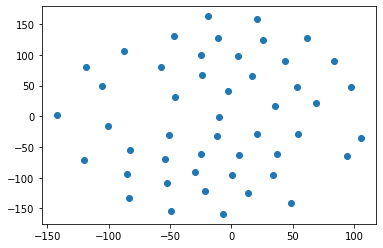

In [13]:
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1])
plt.show()

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(pose_arr)

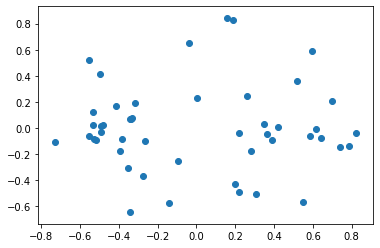

In [4]:
plt.scatter(pca[:,0], pca[:,1])
plt.show()

In [17]:
pca[[26, 25]]

array([[ 0.58531649, -0.06191912],
       [-0.52686389, -0.08037044]])